In [1]:
import sys
sys.path.append('/home/airplaneless/source/Skoltech/CIG/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('bmh')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

In [2]:
plt.matplotlib.rcParams['axes.labelsize'] = 14#12#14
plt.matplotlib.rcParams['font.size'] = 14#12#14
plt.matplotlib.rcParams['axes.titlesize'] = 14#12#14

In [16]:
brats_class_map = {0: 'WT', 1: 'TC', 2: 'ET'}
brats_image_map = {0: 'T1', 1: 'T2', 2: 'T1ce', 3: 'FLAIR'}

def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    for i in range(1, num_classes):
        true_1_hot = (true>=i).float().flatten()
        pred_1_hot = (pmask>=i).float().flatten()
        intersection = torch.sum(pred_1_hot * true_1_hot)
        cardinality = torch.sum(pred_1_hot + true_1_hot)
        dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls

def dice_coeff_2d_classes(true, logits, z, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    for i in range(1, num_classes):
        true_1_hot = (true[:,z]>=i).float().flatten()
        pred_1_hot = (pmask[:,z]>=i).float().flatten()
        intersection = torch.sum(pred_1_hot * true_1_hot)
        cardinality = torch.sum(pred_1_hot + true_1_hot)
        dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls

def plot_image_mask(idx, slice_z, dataset, sampling, cmap_image=plt.cm.bone, cmap_mask=plt.cm.binary_r, scale=2, dpi=90, zoom=0.454):
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(scale * 4, scale * 1), dpi=dpi,
                           subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                           gridspec_kw=dict(wspace=0.0, hspace=0.0))
    mask, image, mean, std = dataset[idx]
    image = (IFt(Ft(image * std + mean) * sampling.cpu()).abs() - mean) / (std + 1e-11)
    for i in range(image.shape[0]):
        ax[i].imshow(image[i, slice_z], cmap=cmap_image)
        ax[i].set_title(brats_image_map[i], c='k')
        mask = torch.ones(60,240) * sampling[i,0,:,0].cpu()
        im = plt.matplotlib.offsetbox.OffsetImage(mask, zoom=zoom, cmap=plt.cm.binary_r)
        im.image.axes = ax[i]
        ab = plt.matplotlib.offsetbox.AnnotationBbox(
            im, (0, 0),
            xybox=(120., 240.),
            pad=-0.2,
            frameon=False,
        )
        ax[i].add_artist(ab)
    return fig, ax

def plot_predictions(idx, slice_z, slize_n, dataset, model_sampling_tuple, cmap_image=plt.cm.bone, cmap_mask=plt.cm.binary_r, scale=2, dpi=90):
    fig, ax = plt.subplots(ncols=len(model_sampling_tuple), nrows=2, figsize=(scale * len(model_sampling_tuple), scale * 2), dpi=dpi,
                           subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                           gridspec_kw=None)
    for i, (model, sampling, name) in enumerate(model_sampling_tuple):
        mask, image, mean, std = dataset[idx]
        image = (IFt(Ft(image * std + mean) * sampling.cpu()).abs() - mean) / (std + 1e-11)
        logit = []
        for j in tqdm(range(image.shape[1]), leave=False):
            with torch.no_grad(): logit.append(model(image.movedim(1,0)[j:j+1].cuda()).movedim(1,0).cpu())
        logit = torch.cat(logit, dim=1)
        scores = dice_coeff_3d_classes(mask, logit.cpu())
        probas = F.softmax(logit, dim=0)
        probas = (probas > 0.5).long()
        pmask = torch.zeros_like(mask)
        pmask[0] = probas[1] * 1 + probas[2] * 2 + probas[3] * 3
        ax[0,i].imshow(image[slize_n, slice_z], cmap=cmap_image)
        ax[0,i].set_title(name, c='k')
        ax[1,i].imshow(pmask[0,slice_z][:200], cmap=cmap_mask)
        scores = '\n'.join(['%s : %.4f' % (brats_class_map[i], s) for i,s in enumerate(scores)])
        ax[1,i].text(50, 40, scores, c='w', ha='center', va='center', fontsize='x-small')
        if i == 0: ax[1,i].set_ylabel('Predicted', c='k')
        if i == 0: ax[0,i].set_ylabel(brats_image_map[slize_n], c='k')
#         ax[2,i].imshow(mask[0,slice_z], cmap=cmap_mask)
#         if i == 0: ax[2,i].set_ylabel('gt', c='g')
    return fig, ax


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug

    def __len__(self) -> int:
        return len(self.hf)
    
    def __getitem__(self, item: int):
        img = self.hf[str(item)][:-1,:,:,:]
        mask = self.hf[str(item)][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std

In [4]:
train_3d_dataset = BraTS3dDataset('/run/media/airplaneless/Backup/DATA/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/run/media/airplaneless/Backup/DATA/brats_h5/val.h5')

In [5]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()
w = torch.load('sampling_igs_finetune.pt').cuda()

model = Unet(4, 4).train(False).eval().cuda()
model.load_state_dict(torch.load('unet-brats-norot-3.pt'))
model_zm = Unet(4, 4).train(False).eval().cuda()
model_zm.load_state_dict(torch.load('model_zm.pt'))
model_igs = Unet(4, 4).train(False).eval().cuda()
model_igs.load_state_dict(torch.load('model_igs.pt'))
model_fastmri = Unet(4, 4).train(False).eval().cuda()
model_fastmri.load_state_dict(torch.load('model_fastmri.pt'))

<All keys matched successfully>

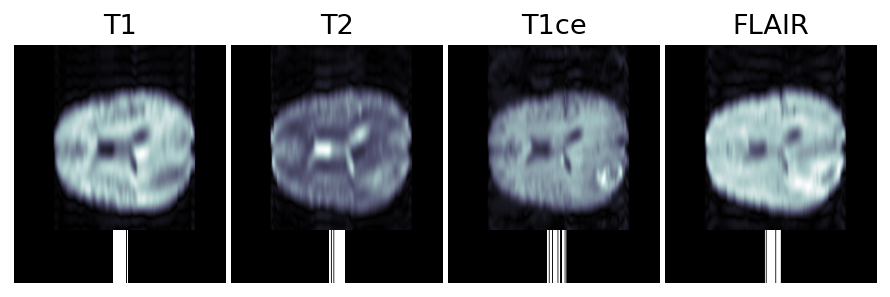

In [6]:
%matplotlib inline
fig, ax = plot_image_mask(idx=0, slice_z=80, dataset=val_3d_dataset, sampling=w.unsqueeze(2).unsqueeze(1), dpi=140, zoom=0.453, scale=2)
plt.savefig('brats-mask-x16.eps', bbox_inches = "tight")

In [7]:
model_sampling_list = [
    (model_fastmri, fastmri_mask_x16, 'FastMRI'),
    (model_zm, zm, 'Center'),
    (model_igs, w.unsqueeze(2).unsqueeze(1), 'Ours'),
    (model, fm, 'Full')
]

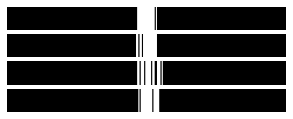

In [8]:
fig, ax = plt.subplots(nrows=4, figsize=(5,2),
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                       gridspec_kw=dict(wspace=0.0, hspace=0.0))
for i in range(4):
    ax[i].imshow(torch.ones((20,240)) * w[i].cpu(), cmap=plt.cm.binary_r)
plt.show()

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

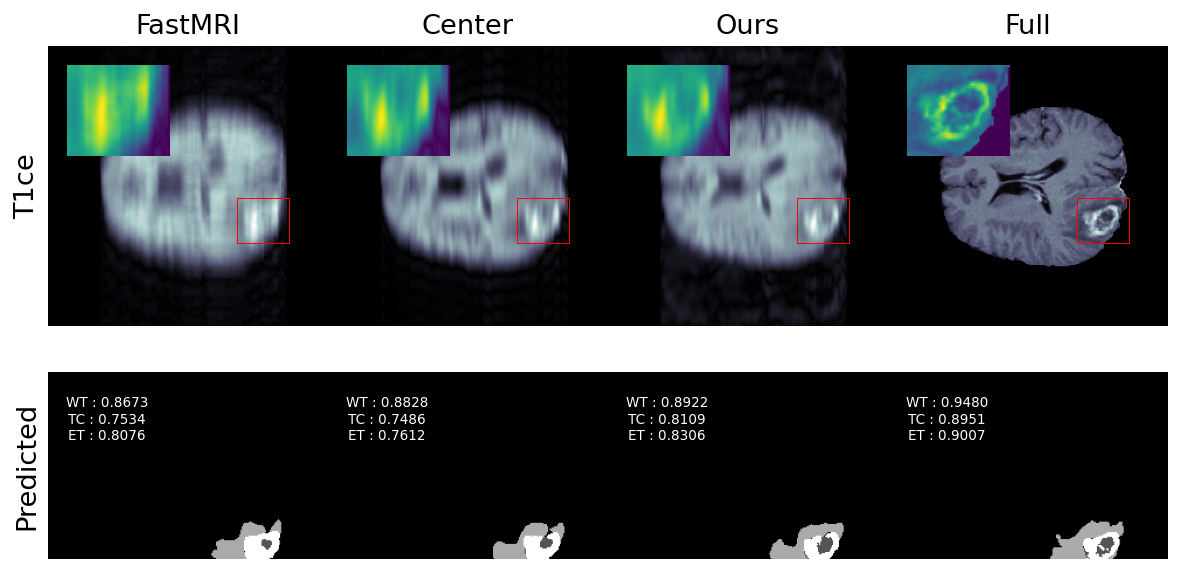

In [9]:
%matplotlib inline
fig, ax = plot_predictions(idx=0, slice_z=80, slize_n=2, dataset=val_3d_dataset, model_sampling_tuple=model_sampling_list, dpi=140)
for i in range(4):
    im = plt.matplotlib.offsetbox.OffsetImage(ax[0,i].images[0].get_array().data[130:130+39,162:162+44], zoom=1.2)
    rect = plt.matplotlib.patches.Rectangle((162, 130), 44, 39, linewidth=0.5, edgecolor='r', facecolor='none')
    im.image.axes = ax[0,i]
    ab = plt.matplotlib.offsetbox.AnnotationBbox(
        im, (0, 0),
        xybox=(60., 55.),
        pad=0.2,
        frameon=False,
    )
    ax[0,i].add_artist(ab)
    ax[0,i].add_patch(rect)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('brats-ex1.eps', bbox_inches = "tight")

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

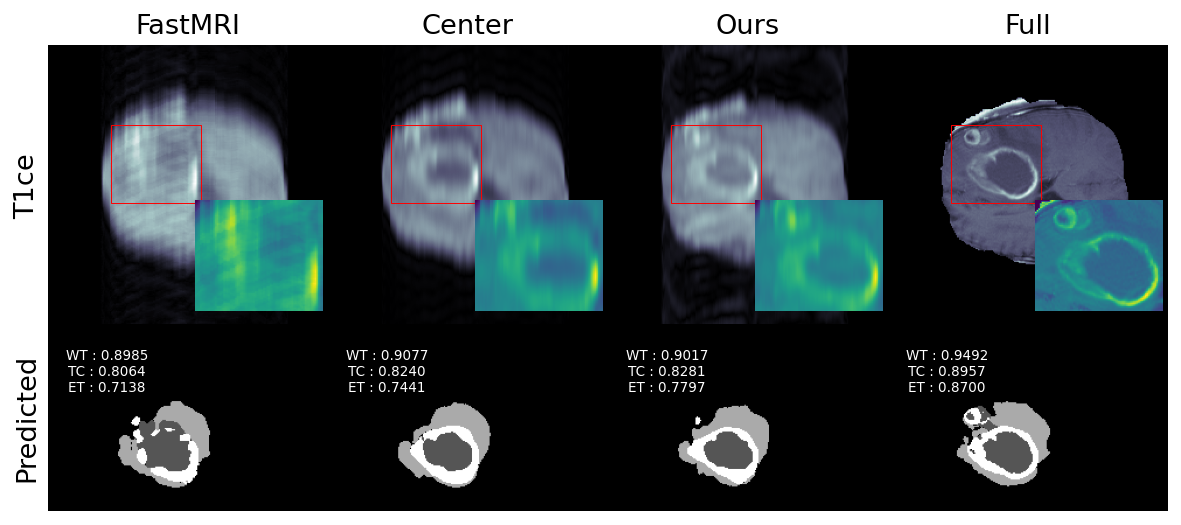

In [10]:
%matplotlib inline
fig, ax = plot_predictions(idx=110, slice_z=80, slize_n=2, dataset=val_3d_dataset, model_sampling_tuple=model_sampling_list, dpi=140)
for i in range(len(ax[0])):
    im = plt.matplotlib.offsetbox.OffsetImage(ax[0,i].images[0].get_array().data[68:135,54:131], zoom=0.85)
    rect = plt.matplotlib.patches.Rectangle((54, 68), 131-54, 135-68, linewidth=0.5, edgecolor='r', facecolor='none')
    im.image.axes = ax[0,i]
    ab = plt.matplotlib.offsetbox.AnnotationBbox(
        im, (0, 0),
        xybox=(180., 180.),
        pad=0.2,
        frameon=False,
    )
    ax[0,i].add_artist(ab)
    ax[0,i].add_patch(rect)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=-0.29)
plt.savefig('brats-ex2.eps', bbox_inches = "tight")

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

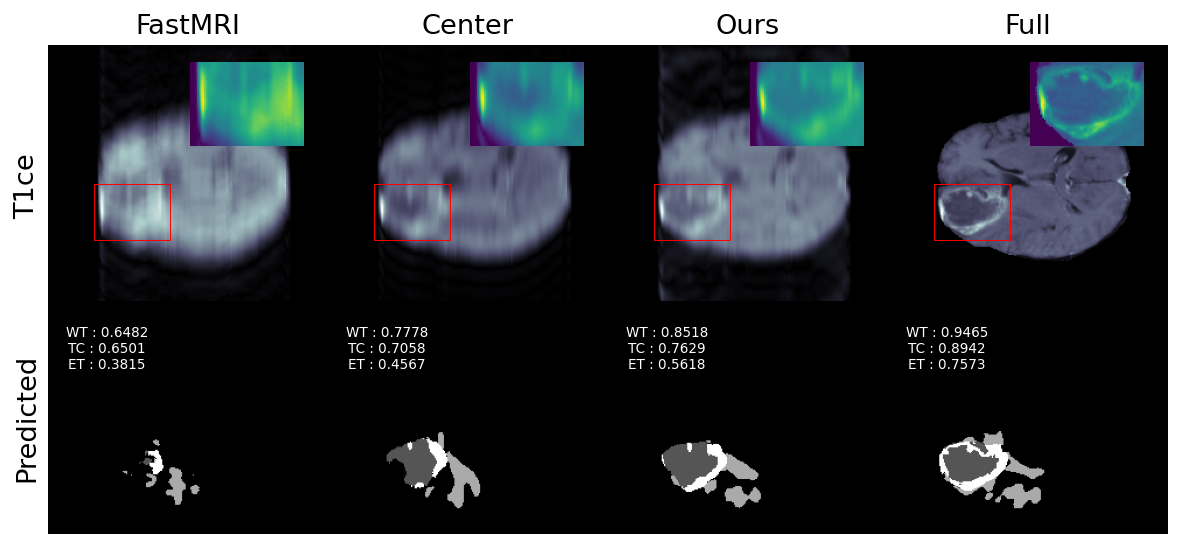

In [17]:
%matplotlib inline
fig, ax = plot_predictions(idx=69, slice_z=80, slize_n=2, dataset=val_3d_dataset, model_sampling_tuple=model_sampling_list, dpi=140)
for i in range(len(ax[0])):
    im = plt.matplotlib.offsetbox.OffsetImage(ax[0,i].images[0].get_array().data[119:167,39:104], zoom=0.9)
    rect = plt.matplotlib.patches.Rectangle((39, 119), 104-39, 167-119, linewidth=0.5, edgecolor='r', facecolor='none')
    im.image.axes = ax[0,i]
    ab = plt.matplotlib.offsetbox.AnnotationBbox(
        im, (0, 0),
        xybox=(170., 50.),
        pad=0.2,
        frameon=False,
    )
    ax[0,i].add_artist(ab)
    ax[0,i].add_patch(rect)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=-0.29)
plt.savefig('brats-ex3.eps', bbox_inches = "tight")

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

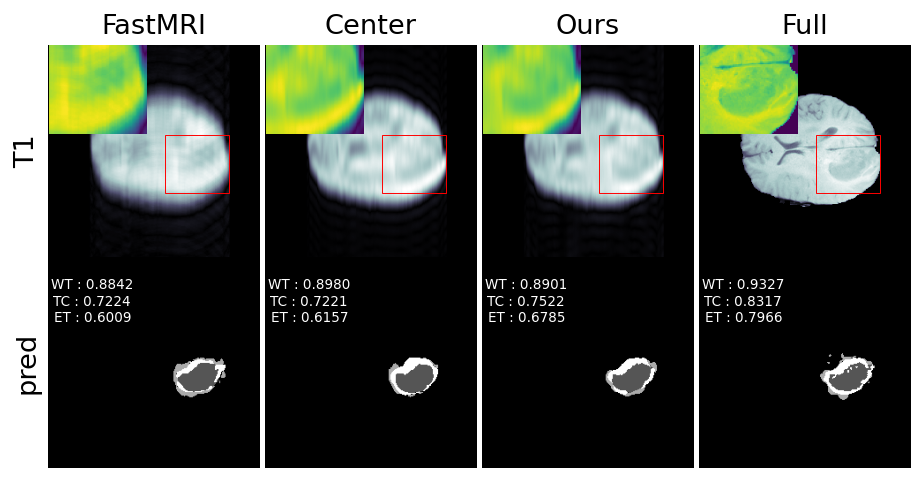

In [11]:
%matplotlib inline
fig, ax = plot_predictions(idx=80, slice_z=80, slize_n=0, dataset=val_3d_dataset, model_sampling_tuple=model_sampling_list, dpi=140)
for i in range(len(ax[0])):
    im = plt.matplotlib.offsetbox.OffsetImage(ax[0,i].images[0].get_array().data[102:167,133:205], zoom=0.7)
    rect = plt.matplotlib.patches.Rectangle((133, 102), 205-133, 167-102, linewidth=0.5, edgecolor='r', facecolor='none')
    im.image.axes = ax[0,i]
    ab = plt.matplotlib.offsetbox.AnnotationBbox(
        im, (0, 0),
        xybox=(56., 50.),
        pad=0.2,
        frameon=False,
    )
    ax[0,i].add_artist(ab)
    ax[0,i].add_patch(rect)
plt.savefig('brats-ex4.eps', bbox_inches = "tight")

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

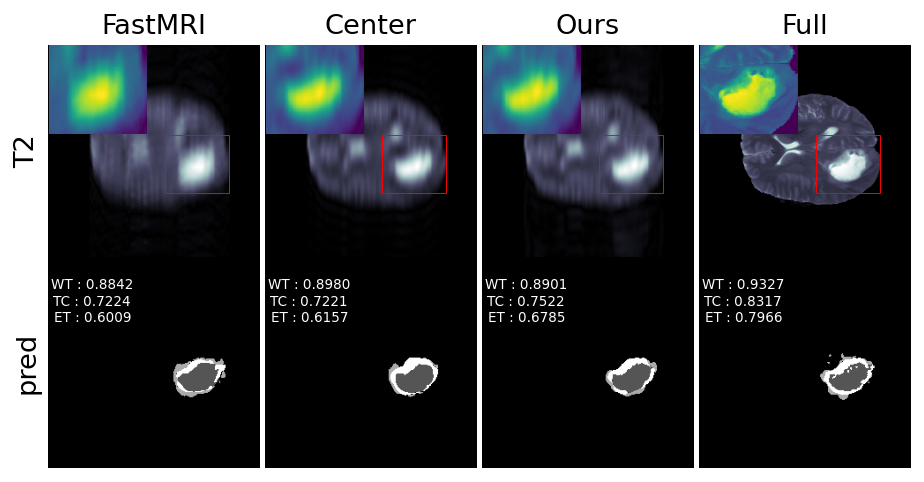

In [12]:
%matplotlib inline
fig, ax = plot_predictions(idx=80, slice_z=80, slize_n=1, dataset=val_3d_dataset, model_sampling_tuple=model_sampling_list, dpi=140)
for i in range(len(ax[0])):
    im = plt.matplotlib.offsetbox.OffsetImage(ax[0,i].images[0].get_array().data[102:167,133:205], zoom=0.7)
    rect = plt.matplotlib.patches.Rectangle((133, 102), 205-133, 167-102, linewidth=0.5, edgecolor='r', facecolor='none')
    im.image.axes = ax[0,i]
    ab = plt.matplotlib.offsetbox.AnnotationBbox(
        im, (0, 0),
        xybox=(56., 50.),
        pad=0.2,
        frameon=False,
    )
    ax[0,i].add_artist(ab)
    ax[0,i].add_patch(rect)
plt.savefig('brats-ex5.eps', bbox_inches = "tight")